# Max-Hege-modell med SPURV-data
## Imports

In [1]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
from pathlib import Path
from ast import literal_eval
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Input, Flatten, Dense, Cropping2D, Dropout, Conv2D, concatenate, TimeDistributed, CuDNNLSTM
import re

import sys
print(sys.version_info)
print(tf.__version__)
print(sys.executable)

sys.version_info(major=3, minor=5, micro=6, releaselevel='final', serial=0)
1.10.0
/home/audun/.conda/envs/carla/bin/python


## Define helper methods

In [2]:
def generate_shadow_coordinates(imshape, no_of_shadows=1):
    vertices_list=[]
    for index in range(no_of_shadows):
        vertex=[]
        for dimensions in range(np.random.randint(3,15)): ## Dimensionality of the shadow polygon
            vertex.append(( imshape[1]*np.random.uniform(),imshape[0]//3+imshape[0]*np.random.uniform()))
        vertices = np.array([vertex], dtype=np.int32) ## single shadow vertices 
        vertices_list.append(vertices)
    return vertices_list ## List of shadow vertices

def add_shadow(image,no_of_shadows=1):
    mask = np.zeros_like(image) 
    imshape = image.shape
    vertices_list= generate_shadow_coordinates(imshape, no_of_shadows) #3 getting list of shadow vertices
    for vertices in vertices_list: 
        cv2.fillPoly(mask, vertices, 255) ## adding all shadow polygons on empty mask, single 255 denotes only red channel
    
    image[:,:,0][mask[:,:,0]==255] = image[:,:,0][mask[:,:,0]==255]*0.2   ## if red channel is hot, image's "Lightness" channel's brightness is lowered 
    return np.array(image, dtype = np.uint8)

def change_brightness(image):
    brightness_coefficient = np.random.uniform(0.3,1.7)
    image[:,:,0] = image[:,:,0]*brightness_coefficient
    image[:,:,0][image[:,:,0]>255]  = 255
    return np.array(image, dtype = np.uint8)

def gaussisan_blur(image):
    image = cv2.GaussianBlur(image,(7,7),0)
    return np.array(image, dtype = np.uint8)

## Parameters

In [3]:
steer_correction = 0.1

## Fetch episodes from dataset


In [4]:
input_images = []
input_info = []
input_hlc = []
outputs = []

dist = {"0":0,"1":0,"2":0,"3":0, "speed_low":0, "speed_high":0}

hlc_one_hot = [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]

MAX_IMAGES = 5000
i = 0
for dataset in glob("data_dump/*/"):
    print(dataset)
    imgs = []
    hlc = []
    info = []
    output = []
    left_output = []
    right_output = []
    chosen_aug = np.random.randint(3)
    
    for index, row in pd.read_csv(dataset+"/data.csv").iterrows():
        if i >= MAX_IMAGES:
            break
        i += 1
        path = Path(dataset)
        imgs.append(str('./' / path / re.sub('/home/kia/data_dump/([A-Za-z]|[0-9]|-|:)*/', '', row["image_path"])))
        
        speed = 0
        speed_limit = 0
        traffic_light = 0
        info.append(np.array([speed,speed_limit,traffic_light]))
        
        hlc.append(np.array(hlc_one_hot[int(row["high_level_command"])]))
        
        #ap_controls = literal_eval(row["APControls"])
        steer = row["angle"]
        throttle = row["speed"]
        #brake = ap_controls[2]
        output.append(np.array([steer,throttle]))
        #left_output.append(np.array([steer+steer_correction,throttle,brake]))
        #right_output.append(np.array([steer-steer_correction,throttle,brake]))
        
        if throttle<0.001:
            dist["speed_low"] += 1
        else:
            dist["speed_high"] += 1
        dist[str(row["high_level_command"])] += 1
        
    
    input_images.append(imgs)
    input_info.append(info)
    input_hlc.append(hlc)
    outputs.append(output)
    
    #input_images.append(left_imgs)
    #input_info.append(info)
    #input_hlc.append(hlc)
    #outputs.append(left_output)

    #input_images.append(right_imgs)
    #input_info.append(info)
    #input_hlc.append(hlc)
    #outputs.append(right_output)

print(dist)

data_dump/2019-10-09T11:07:52/
{'1': 5000, '3': 0, '0': 0, 'speed_high': 5000, 'speed_low': 0, '2': 0}


## Balance data

In [5]:
input_images_b = []
input_info_b = []
input_hlc_b = []
outputs_b = []

total = dist["speed_low"] + dist["speed_high"]
target_speed = int(total * 0.05)
keep_every_speed = int(dist["speed_low"] / target_speed)

keep_every_straight = 4


dist_b = {"0":0,"1":0,"2":0,"3":0, "speed_low":0, "speed_high":0}

speed_num=0
straight_num=0

for e in range(len(input_images)):
    imgs = []
    info = []
    hlc = []
    output = []
    for o in range(len(input_images[e])):
        keep = True
        
        speed = input_info[e][o][0]
        traffic_light = input_info[e][o][2]
        hlc_cmd = np.argmax(input_hlc[e][o])
        angle = outputs[e][o][0]
        
        if speed<0.001:
            #if speed_num % keep_every_speed != 0 and traffic_light is 1:
            #    keep = False
            speed_num += 1
        
        if hlc_cmd == 0:
            if abs(angle)<0.3:
                #if straight_num % keep_every_straight != 0:
                #    keep = False
                straight_num += 1

        if keep:
            if speed<0.001:
                dist_b["speed_low"] += 1
            else:
                dist_b["speed_high"] += 1
            dist_b[str(hlc_cmd)] += 1
            
            imgs.append(input_images[e][o])
            info.append(input_info[e][o])
            hlc.append(input_hlc[e][o])
            output.append(outputs[e][o])
    input_images_b.append(imgs)
    input_info_b.append(info)
    input_hlc_b.append(hlc)
    outputs_b.append(output)

input_images = input_images_b
input_info = input_info_b
input_hlc = input_hlc_b
outputs = outputs_b

print(dist_b)

{'1': 5000, '3': 0, '0': 0, 'speed_high': 0, 'speed_low': 5000, '2': 0}


## Load images

In [6]:
images = []

for e in range(len(input_images)):
    imgs = []
    for o in range(len(input_images[e])):
        path = input_images[e][o]
        try:
            read = cv2.imread(path)
            imgs.append(cv2.cvtColor(cv2.resize(read, (0, 0), fx=0.5, fy=0.5), cv2.COLOR_BGR2LAB))
        except:
            print("Failed to locate " + path)
    images.append(imgs)
    
input_images = images
print("Done")


Done


## Augument data and shuffle


In [7]:
print("Episodes before augmentation: " + str(len(input_images)))

for e in range(len(input_images)):
    imgs = []
    chosen_aug = np.random.randint(3)
    for o in range(len(input_images[e])):
        img = input_images[e][o]
        
        aug_img = np.array(img, dtype = np.float64) 
        
        if chosen_aug is 0:
            aug_img = change_brightness(aug_img)
        elif chosen_aug is 1:
            aug_img = add_shadow(aug_img, no_of_shadows=3)
        elif chosen_aug is 2:
            aug_img = gaussisan_blur(aug_img)
        imgs.append(aug_img)
    input_images.append(imgs)
    input_info.append(input_info[e])
    input_hlc.append(input_hlc[e])
    outputs.append(outputs[e])


permutation = np.random.permutation(len(input_images))    

input_images = np.array(input_images)[permutation]
input_info = np.array(input_info)[permutation]
input_hlc = np.array(input_hlc)[permutation]
outputs = np.array(outputs)[permutation]

print(input_images.shape)
print(input_info.shape)
print(input_hlc.shape)
print(outputs.shape)


Episodes before augmentation: 1
(2, 5000, 162, 216, 3)
(2, 5000, 3)
(2, 5000, 4)
(2, 5000, 2)


## Data generator

In [8]:
seq_length = 5
seq_space = 2

m3_input_images = []
m3_input_info = []
m3_input_hlc = []
m3_outputs = []

data = input_images
sliced_data = []
for e in range(len(data)):
    slices = []
    for o in range(seq_space+1):
        # data[e] is images from episode e
        # 
        slices.append(data[e][o::seq_space+1])
    for s in slices:
        for o in range(0,len(s)):
            if o + seq_length <= len(s):
                sliced_data.append(s[o:o+seq_length])
m3_input_images = sliced_data

data = input_info
sliced_data = []
for e in range(len(data)):
    slices = []
    for o in range(seq_space+1):
        slices.append(data[e][o::seq_space+1])
    for s in slices:
        for o in range(0,len(s)):
            if o + seq_length <= len(s):
                sliced_data.append(s[o:o+seq_length])
m3_input_info = sliced_data

data = input_hlc
sliced_data = []
for e in range(len(data)):
    slices = []
    for o in range(seq_space+1):
        slices.append(data[e][o::seq_space+1])
    for s in slices:
        for o in range(0,len(s)):
            if o + seq_length <= len(s):
                sliced_data.append(s[o:o+seq_length])
m3_input_hlc = sliced_data

data = outputs
sliced_data = []
for e in range(len(data)):
    slices = []
    for o in range(seq_space+1):
        slices.append(data[e][o::seq_space+1])
    for s in slices:
        for o in range(0,len(s)):
            if o + seq_length <= len(s):
                sliced_data.append(s[o+seq_length-1])
m3_outputs = sliced_data


def generator(batch_size, val_split, val=False):

    # Create empty arrays to contain batch of features and labels#

    while True:
        l = len(m3_input_images)
        if not val:
            index= np.random.randint(0,l-int(l*val_split)-batch_size)
        else:
            index= np.random.randint(l-int(l*val_split), l-batch_size)
        imgs = np.array(m3_input_images[index:index+batch_size])
        info = np.array(m3_input_info[index:index+batch_size])
        hlc = np.array(m3_input_hlc[index:index+batch_size])
        output = np.array(m3_outputs[index:index+batch_size])
        steer_pred = output[:,0]
        throttle_pred = output[:,1]
        brake_pred = np.zeros(batch_size) # output[:,2]

        yield {"forward_image_input": imgs, "hlc_input": hlc}, {"steer_pred": steer_pred, "throttle_pred": throttle_pred}

print(len(m3_input_images))
print(len(m3_input_info))
print(len(m3_input_hlc))
print(len(m3_outputs))


9976
9976
9976
9976


In [9]:
next(generator(32, 0.5))

({'forward_image_input': array([[[[[147, 131, 102],
            [155, 131, 103],
            [161, 131, 103],
            ...,
            [137, 123, 131],
            [ 75, 128, 121],
            [ 60, 130, 119]],
  
           [[156, 131, 103],
            [162, 131, 103],
            [165, 131, 103],
            ...,
            [153, 121, 137],
            [146, 126, 127],
            [109, 130, 120]],
  
           [[162, 131, 103],
            [167, 131, 103],
            [170, 131, 103],
            ...,
            [124, 123, 136],
            [147, 126, 133],
            [134, 127, 127]],
  
           ...,
  
           [[ 28, 128, 130],
            [ 26, 128, 130],
            [ 22, 128, 130],
            ...,
            [ 22, 128, 129],
            [ 23, 128, 130],
            [ 38, 126, 130]],
  
           [[ 39, 128, 129],
            [ 34, 130, 126],
            [ 45, 129, 126],
            ...,
            [ 48, 128, 129],
            [ 48, 128, 128],
            [ 48

## Verify some random images

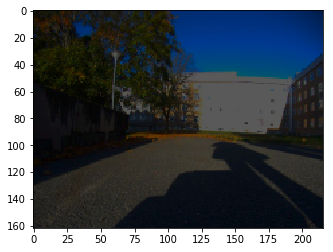

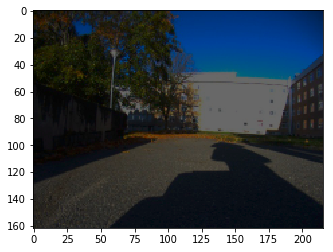

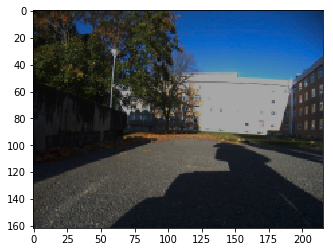

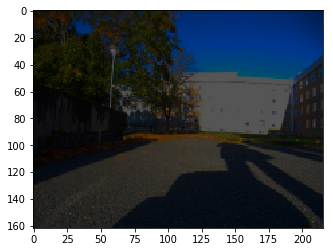

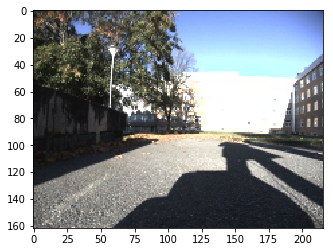

In [10]:
check = 990
for t in range(len(m3_input_images[check])):
    img = m3_input_images[check][t]
    img = cv2.cvtColor(img,cv2.COLOR_LAB2RGB)
    plt.imshow(img)
    plt.show()

## Define Max-Hege model

### Steering prediction network

In [11]:
# forward_image_input = Input(shape=(seq_length, 160, 350, 3), name='forward_image_input')
forward_image_input = Input(shape=(seq_length, 162, 216, 3), name='forward_image_input')
# info_input = Input(shape=(seq_length, 3), name='info_input')
# hlc_input = Input(shape=(seq_length, 6), name='hlc_input')
hlc_input = Input(shape=(seq_length, 4), name='hlc_input')

x = TimeDistributed(Cropping2D(cropping=((50, 0), (0,
                    0))))(forward_image_input)
# x = TimeDistributed(Lambda(lambda x: x / 255.0 - 0.5))(x)
x = TimeDistributed(Conv2D(24, (5, 5), strides=(2, 2), activation='relu'
                    ))(x)
x = TimeDistributed(Conv2D(36, (5, 5), strides=(2, 2), activation='relu'
                    ))(x)
x = TimeDistributed(Conv2D(48, (5, 5), strides=(2, 2), activation='relu'
                    ))(x)
x = TimeDistributed(Conv2D(64, (3, 3), strides=(2, 2), activation='relu'
                    ))(x)
x = TimeDistributed(Conv2D(64, (3, 3), activation='relu'))(x)
x = TimeDistributed(Conv2D(64, (3, 3), activation='relu'))(x)
conv_output = TimeDistributed(Flatten())(x)
x = concatenate([conv_output, hlc_input])
x = TimeDistributed(Dense(100, activation='relu'))(x)
x = CuDNNLSTM(10, return_sequences=False)(x)
steer_pred = Dense(1, activation='tanh', name='steer_pred')(x)

### Throttle & brake prediction network

In [12]:
x = TimeDistributed(Cropping2D(cropping=((50, 0), (0,
                    0))))(forward_image_input)
# x = TimeDistributed(Lambda(lambda x: x / 255.0 - 0.5))(x)
x = TimeDistributed(Conv2D(24, (5, 5), strides=(2, 2), activation='relu'
                    ))(x)
x = TimeDistributed(Conv2D(36, (5, 5), strides=(2, 2), activation='relu'
                    ))(x)
x = TimeDistributed(Conv2D(48, (5, 5), strides=(2, 2), activation='relu'
                    ))(x)
x = TimeDistributed(Conv2D(64, (3, 3), strides=(2, 2), activation='relu'
                    ))(x)
x = TimeDistributed(Conv2D(64, (3, 3), activation='relu'))(x)
x = TimeDistributed(Conv2D(64, (3, 3), activation='relu'))(x)
conv_output = TimeDistributed(Flatten())(x)
x = concatenate([conv_output, hlc_input])
x = TimeDistributed(Dense(100, activation='relu'))(x)
x = CuDNNLSTM(10, return_sequences=False)(x)
throtte_pred = Dense(1, name='throttle_pred')(x)
#brake_pred = Dense(1, name='brake_pred')(x)

### Whole model
Concatinates the two networks defined before

In [13]:
model_name = "hege-max-spurv"
model = Model(inputs=[forward_image_input, hlc_input],
              outputs=[steer_pred, throtte_pred])

from tensorflow.keras.utils import plot_model 
plot_model(model, to_file='model.png')
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
forward_image_input (InputLayer (None, 5, 162, 216,  0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 5, 112, 216,  0           forward_image_input[0][0]        
__________________________________________________________________________________________________
time_distributed_9 (TimeDistrib (None, 5, 112, 216,  0           forward_image_input[0][0]        
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 5, 54, 106, 2 1824        time_distributed[0][0]           
__________________________________________________________________________________________________
time_distr

## Train network

In [14]:
model.compile(loss='mse', optimizer='rmsprop')

path = 'models/'+model_name
checkpoint_val = ModelCheckpoint(path+'/model1_e{epoch:02d}_val_{val_loss:.4f}.h5', monitor='val_loss', verbose=1, save_best_only=True,mode="min")
checkpoint_loss = ModelCheckpoint(path+'/model1_e{epoch:02d}_loss_{loss:.4f}.h5', monitor='loss', verbose=1, save_best_only=True,mode="min")
if not os.path.exists(path):
    os.makedirs(path)

Epoch 1/100
249/250 [============================>.] - ETA: 0s - loss: 0.0224 - steer_pred_loss: 0.0224 - throttle_pred_loss: 1.3013e-05
Epoch 00001: val_loss did not improve from 0.01549

Epoch 00001: loss did not improve from 0.01749
250/250 [==============================] - 25s 102ms/step - loss: 0.0225 - steer_pred_loss: 0.0225 - throttle_pred_loss: 1.2962e-05 - val_loss: 0.0173 - val_steer_pred_loss: 0.0173 - val_throttle_pred_loss: 2.1882e-05
Epoch 2/100
249/250 [============================>.] - ETA: 0s - loss: 0.0198 - steer_pred_loss: 0.0198 - throttle_pred_loss: 1.2612e-05
Epoch 00002: val_loss did not improve from 0.01549

Epoch 00002: loss did not improve from 0.01749
250/250 [==============================] - 26s 103ms/step - loss: 0.0197 - steer_pred_loss: 0.0197 - throttle_pred_loss: 1.2653e-05 - val_loss: 0.0177 - val_steer_pred_loss: 0.0177 - val_throttle_pred_loss: 1.5995e-05
Epoch 3/100
249/250 [============================>.] - ETA: 0s - loss: 0.0159 - steer_pred_l

Epoch 19/100
249/250 [============================>.] - ETA: 0s - loss: 0.0167 - steer_pred_loss: 0.0167 - throttle_pred_loss: 1.5380e-05
Epoch 00019: val_loss did not improve from 0.01549

Epoch 00019: loss did not improve from 0.01550
250/250 [==============================] - 26s 102ms/step - loss: 0.0166 - steer_pred_loss: 0.0166 - throttle_pred_loss: 1.5351e-05 - val_loss: 0.0163 - val_steer_pred_loss: 0.0162 - val_throttle_pred_loss: 1.5792e-05
Epoch 20/100
249/250 [============================>.] - ETA: 0s - loss: 0.0199 - steer_pred_loss: 0.0199 - throttle_pred_loss: 1.3532e-05
Epoch 00020: val_loss did not improve from 0.01549

Epoch 00020: loss did not improve from 0.01550
250/250 [==============================] - 25s 102ms/step - loss: 0.0198 - steer_pred_loss: 0.0198 - throttle_pred_loss: 1.3508e-05 - val_loss: 0.0165 - val_steer_pred_loss: 0.0165 - val_throttle_pred_loss: 1.3303e-05
Epoch 21/100
249/250 [============================>.] - ETA: 0s - loss: 0.0200 - steer_pre

Epoch 37/100
249/250 [============================>.] - ETA: 0s - loss: 0.0177 - steer_pred_loss: 0.0177 - throttle_pred_loss: 1.3679e-05
Epoch 00037: val_loss did not improve from 0.01549

Epoch 00037: loss did not improve from 0.01461
250/250 [==============================] - 26s 102ms/step - loss: 0.0178 - steer_pred_loss: 0.0177 - throttle_pred_loss: 1.3629e-05 - val_loss: 0.0177 - val_steer_pred_loss: 0.0176 - val_throttle_pred_loss: 2.0171e-05
Epoch 38/100
249/250 [============================>.] - ETA: 0s - loss: 0.0177 - steer_pred_loss: 0.0177 - throttle_pred_loss: 1.4743e-05
Epoch 00038: val_loss did not improve from 0.01549

Epoch 00038: loss did not improve from 0.01461
250/250 [==============================] - 26s 103ms/step - loss: 0.0177 - steer_pred_loss: 0.0177 - throttle_pred_loss: 1.4797e-05 - val_loss: 0.0192 - val_steer_pred_loss: 0.0192 - val_throttle_pred_loss: 1.4728e-05
Epoch 39/100
249/250 [============================>.] - ETA: 0s - loss: 0.0169 - steer_pre

Epoch 55/100
249/250 [============================>.] - ETA: 0s - loss: 0.0154 - steer_pred_loss: 0.0154 - throttle_pred_loss: 1.4126e-05
Epoch 00055: val_loss did not improve from 0.01462

Epoch 00055: loss did not improve from 0.01429
250/250 [==============================] - 26s 103ms/step - loss: 0.0154 - steer_pred_loss: 0.0153 - throttle_pred_loss: 1.4264e-05 - val_loss: 0.0174 - val_steer_pred_loss: 0.0174 - val_throttle_pred_loss: 1.6443e-05
Epoch 56/100
249/250 [============================>.] - ETA: 0s - loss: 0.0178 - steer_pred_loss: 0.0178 - throttle_pred_loss: 1.3868e-05
Epoch 00056: val_loss did not improve from 0.01462

Epoch 00056: loss did not improve from 0.01429
250/250 [==============================] - 26s 103ms/step - loss: 0.0178 - steer_pred_loss: 0.0177 - throttle_pred_loss: 1.3918e-05 - val_loss: 0.0172 - val_steer_pred_loss: 0.0172 - val_throttle_pred_loss: 1.4620e-05
Epoch 57/100
249/250 [============================>.] - ETA: 0s - loss: 0.0159 - steer_pre

249/250 [============================>.] - ETA: 0s - loss: 0.0193 - steer_pred_loss: 0.0192 - throttle_pred_loss: 1.4275e-05
Epoch 00073: val_loss did not improve from 0.01462

Epoch 00073: loss did not improve from 0.01429
250/250 [==============================] - 27s 106ms/step - loss: 0.0193 - steer_pred_loss: 0.0193 - throttle_pred_loss: 1.4455e-05 - val_loss: 0.0164 - val_steer_pred_loss: 0.0164 - val_throttle_pred_loss: 1.7029e-05
Epoch 74/100
249/250 [============================>.] - ETA: 0s - loss: 0.0175 - steer_pred_loss: 0.0175 - throttle_pred_loss: 1.3871e-05
Epoch 00074: val_loss did not improve from 0.01462

Epoch 00074: loss did not improve from 0.01429
250/250 [==============================] - 26s 104ms/step - loss: 0.0175 - steer_pred_loss: 0.0175 - throttle_pred_loss: 1.3869e-05 - val_loss: 0.0180 - val_steer_pred_loss: 0.0180 - val_throttle_pred_loss: 1.5595e-05
Epoch 75/100
249/250 [============================>.] - ETA: 0s - loss: 0.0189 - steer_pred_loss: 0.018

249/250 [============================>.] - ETA: 0s - loss: 0.0181 - steer_pred_loss: 0.0181 - throttle_pred_loss: 1.3767e-05
Epoch 00091: val_loss did not improve from 0.01462

Epoch 00091: loss did not improve from 0.01429
250/250 [==============================] - 25s 101ms/step - loss: 0.0181 - steer_pred_loss: 0.0181 - throttle_pred_loss: 1.3711e-05 - val_loss: 0.0181 - val_steer_pred_loss: 0.0181 - val_throttle_pred_loss: 2.3721e-05
Epoch 92/100
249/250 [============================>.] - ETA: 0s - loss: 0.0148 - steer_pred_loss: 0.0148 - throttle_pred_loss: 1.2845e-05
Epoch 00092: val_loss did not improve from 0.01462

Epoch 00092: loss did not improve from 0.01429
250/250 [==============================] - 25s 101ms/step - loss: 0.0155 - steer_pred_loss: 0.0155 - throttle_pred_loss: 1.2795e-05 - val_loss: 0.0186 - val_steer_pred_loss: 0.0185 - val_throttle_pred_loss: 2.4579e-05
Epoch 93/100
249/250 [============================>.] - ETA: 0s - loss: 0.0153 - steer_pred_loss: 0.015

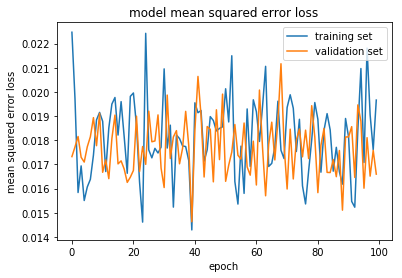

In [16]:
#history_object = model.fit({"image_input": m3_input_images, "info_input": m3_input_info, "hlc_input": m3_input_hlc},m3_outputs, validation_split=0.2, epochs=100, verbose=1, callbacks=[checkpoint_val, checkpoint_loss])
history_object = model.fit_generator(generator(32,0.2,), validation_data=generator(32,0.2,val=True), epochs=100, verbose=1, callbacks=[checkpoint_val, checkpoint_loss], steps_per_epoch=250,validation_steps =200)


plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()